In [1]:
from os.path import join
import numpy as np
from scipy import stats
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [3]:
style.use(join("..", "style.mplstyle"))

In [4]:
posterior = xr.load_dataset("../model-results/posterior.nc")
posterior

<xarray.Dataset>
Dimensions:                        (draw: 4000, chain: 16, X*_dim_0: 3,
                                    X*_dim_1: 7, sigma abundance_dim_0: 3,
                                    sigma abundance_dim_1: 7,
                                    sigma d13C_dim_0: 3, sigma d13C_dim_1: 7,
                                    X_dim_0: 3, X_dim_1: 7, M_dim_0: 3,
                                    M_dim_1: 7, C_dim_0: 3, C_dim_1: 7,
                                    ...
                                    Community Methane Index_dim_0: 3,
                                    Community Methane Index_dim_1: 1,
                                    Location Methane Index_dim_0: 3,
                                    Location Methane Index_dim_1: 1,
                                    D_dim_0: 3, Community TEX86_dim_0: 3,
                                    Location TEX86_dim_0: 3)
Coordinates: (12/23)
  * draw                           (draw) int32 0 1 2 3 ... 3996 3997 3998 3999
  * chain                          (chain) int32 0 1 2 3 4 5 ... 11 12 13 14 15
  * X*_dim_1                       (X*_dim_1) int32 0 1 2 3 4 5 6
  * sigma abundance_dim_1          (sigma abundance_dim_1) int32 0 1 2 3 4 5 6
  * sigma d13C_dim_1               (sigma d13C_dim_1) int32 0 1 2 3 4 5 6
  * X_dim_1                        (X_dim_1) int32 0 1 2 3 4 5 6
    ...                             ...
  * Location Methane Index_dim_0   (Location Methane Index_dim_0) int32 0 1 2
  * Community TEX86_dim_0          (Community TEX86_dim_0) int32 0 1 2
  * Location TEX86_dim_0           (Location TEX86_dim_0) int32 0 1 2
  * C_dim_0                        (C_dim_0) int32 0 1 2
  * Community Methane Index_dim_1  (Community Methane Index_dim_1) int32 0
  * Location Methane Index_dim_1   (Location Methane Index_dim_1) int32 0
Data variables:
    X*                             (chain, draw, X*_dim_0, X*_dim_1) float64 ...
    sigma abundance                (chain, draw, sigma abundance_dim_0, sigma abundance_dim_1) float64 ...
    sigma d13C                     (chain, draw, sigma d13C_dim_0, sigma d13C_dim_1) float64 ...
    X                              (chain, draw, X_dim_0, X_dim_1) float64 0....
    M                              (chain, draw, M_dim_0, M_dim_1) float64 0....
    C                              (chain, draw, C_dim_0, C_dim_1) float64 -5...
    F                              (chain, draw, F_dim_0, F_dim_1) float64 0....
    Community Methane Index        (chain, draw, Community Methane Index_dim_0, Community Methane Index_dim_1) float64 ...
    Location Methane Index         (chain, draw, Location Methane Index_dim_0, Location Methane Index_dim_1) float64 ...
    D                              (chain, draw, D_dim_0) float64 -18.98 ... ...
    Community TEX86                (chain, draw, Community TEX86_dim_0) float64 ...
    Location TEX86                 (chain, draw, Location TEX86_dim_0) float64 ...
Attributes:
    created_at:                 2024-03-19T22:58:54.633718
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              593.1280488967896
    tuning_steps:               4000

In [5]:
times = np.linspace(0, 1, 7)
GDGTs = ["G0", "G1", "G2", "G3", "G4", "Cren", "G5"]
communities = [
    "planktonic",
    "benthic-methane cycling",
    "benthic-non-methane cycling",
]

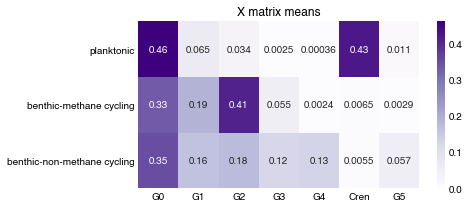

In [6]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.heatmap(
    posterior["X"].mean(dim=("chain", "draw")).values,
    vmin=0,
    annot=True,
    cmap="Purples",
)
ax.set_title("X matrix means")
ax.set_yticks(np.linspace(0.5, 2.5, 3))
ax.set_yticklabels([com.replace("/", "\n") for com in communities], rotation=0)
ax.set_xticks(np.linspace(0.5, 6.5, 7))
ax.set_xticklabels([comp.replace(" ", "\n") for comp in GDGTs])
fig.tight_layout()

In [7]:
def peak(z, area, mu, sigma):
    return area * stats.norm(loc=mu, scale=sigma).pdf(z)

In [8]:
def peaks(z, area, mu, sigma):
    assert len(mu) == len(area)
    return sum(peak(z, area[i], mu[i], sigma) for i in range(len(mu)))

In [9]:
def synthetic_peaks(ax, X, locs, sigma=1):
    assert X.ndim == 2
    assert len(locs) == X.shape[0] == 7
    z = np.linspace(np.min(locs) - 2 * sigma, np.max(locs) + 2 * sigma, 2001)
    ax.fill_between(
        z,
        peaks(z, np.quantile(X, 0.025, axis=1), locs, sigma),
        peaks(z, np.quantile(X, 0.975, axis=1), locs, sigma),
        color="C0",
        linewidth=0.5,
        alpha=0.2,
        label="95th percentile",
    )
    ax.fill_between(
        z,
        peaks(z, np.quantile(X, 0.25, axis=1), locs, sigma),
        peaks(z, np.quantile(X, 0.75, axis=1), locs, sigma),
        color="C1",
        linewidth=0.5,
        alpha=0.6,
        label="50th percentile",
    )
    ax.plot(
        z,
        peaks(z, X.mean(axis=1), locs, sigma),
        color="k",
        linewidth=1,
        label="mean",
    )
    return None

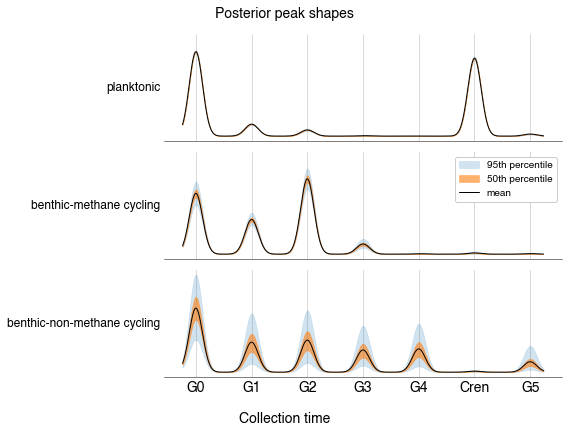

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)
for i in range(3):
    X = posterior["X"].stack(sample=("chain", "draw")).values[i, ...]
    synthetic_peaks(axs[i], X, times, 0.02)
    for t in times:
        axs[i].axvline(t, alpha=0.15, color="k", linewidth=1, zorder=-1)
    axs[i].set_yticks([])
    axs[i].grid(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].set_ylabel(communities[i], rotation=0, ha="right", va="center", fontsize=12)
axs[1].legend()
axs[2].set_xticks(times)
axs[2].set_xticklabels(GDGTs, fontsize=14)
fig.supxlabel("Collection time", fontsize=14)
fig.suptitle("Posterior peak shapes", fontsize=14)
fig.tight_layout()
plt.savefig("../manuscript-figures/post_peak_shapes.png", dpi=400)